# Sentiment Analysis of Twitter Data in Python

we are going to perform the Sentiment Analysis of Twitter data live through Twitter’s API.

In [299]:
# import Libraries

import tweepy
import pandas as pd
import numpy as np
import string
import re

import preprocessor as p
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from textblob import TextBlob

import nltk
nltk.download('stopwords')


from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\waleed
[nltk_data]     traders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) Business Understanding

Twitter Sentiment Analysis helps to understand people’s views and feelings. It provides additional metrics to analyze the performance of products and services and provides opportunities for improvement.


We are going to perform these tasks :

1) Scraping tweets through Twitter's tweepy API about a particular topic. 

2) Predict writer's attitude or views towards a particular topic, product, etc. regarding sentiments (positive, negative, or neutral) in terms of percentage. 

3) What is the frequency or the importance of each word in tweets regarding sentiments. 

4) What are top hashtags in tweets.

    
# 2) Data Understanding

## Gathering Data

In [300]:
# twitter App access keys for @user
 
# Consumer
CONSUMER_KEY    = '1A1p7FrKfEYoVpjG4jSKloEB6'
CONSUMER_SECRET = 'Z4lxkyok4riQrqNQoyGznhPTjksSk4P9yfIctn4NagpSlHVQlf'
 
# Access:
ACCESS_TOKEN  = '886272234-P4ECVJQwZTzBxIsrSH6yR8xuOTGjv5Me5sQZiK3A'
ACCESS_SECRET = '8OhCtzsKI9cGx6ICMwdoCl4hWfHm3ejiuwxTjZEBOSBjC'

In [301]:
def app_auth():
    
    """
    Authenticate our program using the credentials,
    then create a Twitter API object with the credentials
    """
    
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    api = tweepy.API(auth)
    return api

## Access 

### 1- Scraping tweets through Twitter's tweepy API about a particular topic. 

In [378]:
tweet_extract = app_auth()

# input for term to be searched and how many tweets to search

search_term = input("Enter keyword or tag to search: ")
no_of_terms = int(input("Enter no: of tweets to search:"))

raw_tweets = tweet_extract.user_timeline(screen_name = search_term, count = no_of_terms)
print('')
print("Number of tweets extracted: {}.\n".format(len(raw_tweets)))

Enter keyword or tag to search: WHO
Enter no: of tweets to search:200

Number of tweets extracted: 199.



In [379]:
# display top 10 tweets

print("10 latest tweets are :\n")
for tweet in raw_tweets[:10]:
    print(tweet.text)
    print('\n')

10 latest tweets are :

This health crisis has already put an immense burden on our economy and if you are not mindful and strategic it cou… https://t.co/4PlnowGgSU


As we put all our resources and energy behind #COVID19, let us also remind ourselves not to compromise on the routi… https://t.co/bCLoMgI3Un


I would like to urge participants to discuss measures to ensure that more vulnerable countries continue to have acc… https://t.co/ud6dk3S8Yk


We have always emphasized the importance of free and quality health care for all and now His Majesty the King is pe… https://t.co/RlSxJcjdfW


The healthcare system of a nation determines that of an entire globe. This is where I see WHO taking a strong lead… https://t.co/2xrIG9EQOt


In times like this #COVID19 pandemic, we are once again asked to reflect on the efforts and importance we have plac… https://t.co/kvO1s4WLcY


For #Bhutan, we always believe that a nation can only grow on the strong foundation of a good healthcare system.
Fo… ht

### Data is noisy contain links, spaces, special cheracters, hashtags etc.

In [380]:
# Creating a DataFrame of fetch tweets

df = pd.DataFrame(data=[tweet.text for tweet in raw_tweets], columns=['Tweets'])
df['ID'] = np.array([tweet.id for tweet in raw_tweets])
df['Date'] = np.array([tweet.created_at for tweet in raw_tweets])
df['Source'] = np.array([tweet.source for tweet in raw_tweets])
df['Likes'] = np.array([tweet.favorite_count for tweet in raw_tweets])
df['Retweets'] = np.array([tweet.retweet_count for tweet in raw_tweets])
display(df.head(10))

,Tweets,ID,Date,Source,Likes,Retweets
0,This health crisis has already put an immense ...,1262842823742836736,2020-05-19 20:29:26,Twitter for iPhone,69,15
1,As we put all our resources and energy behind ...,1262842109226356737,2020-05-19 20:26:35,Twitter for iPhone,93,25
2,I would like to urge participants to discuss m...,1262840809390571525,2020-05-19 20:21:26,Twitter for iPhone,58,20
3,We have always emphasized the importance of fr...,1262840271882108929,2020-05-19 20:19:17,Twitter for iPhone,37,10
4,The healthcare system of a nation determines t...,1262839667688378373,2020-05-19 20:16:53,Twitter for iPhone,37,12
5,"In times like this #COVID19 pandemic, we are o...",1262839134323986434,2020-05-19 20:14:46,Twitter for iPhone,42,15
6,"For #Bhutan, we always believe that a nation c...",1262838679933984769,2020-05-19 20:12:58,Twitter for iPhone,56,17
7,We are living in extraordinary times. But as m...,1262838307039465474,2020-05-19 20:11:29,Twitter for iPhone,66,16
8,This #COVID19 pandemic has also put us at a cr...,1262831345505632257,2020-05-19 19:43:49,Twitter for iPhone,130,49
9,All of us are equal. The #coronavirus certainl...,1262830706230800384,2020-05-19 19:41:17,Twitter for iPhone,158,58


## The columns we need to have non-null values to anwer the question is:

### Tweets


###  Missing values

1- Some tweets have 0 values in Likes column it is not missing values , user didn't  respond or  like the tweets

2- Some tweets have 0 values in Retweets column it is not missing values, user didn't respond or retweet the tweets

In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 6 columns):
Tweets      199 non-null object
ID          199 non-null int64
Date        199 non-null datetime64[ns]
Source      199 non-null object
Likes       199 non-null int32
Retweets    199 non-null int32
dtypes: datetime64[ns](1), int32(2), int64(1), object(2)
memory usage: 7.9+ KB


In [382]:
df.describe()

,ID,Likes,Retweets
count,1.990000e+02,199.000000,199.000000
mean,1.262359e+18,214.316583,105.849246
std,2.897622e+14,336.459725,159.878102
min,1.261650e+18,0.000000,10.000000
25%,1.262326e+18,68.500000,35.500000
50%,1.262349e+18,118.000000,56.000000
75%,1.262495e+18,247.500000,100.000000
max,1.262843e+18,3259.000000,1392.000000


In [383]:
print(df.isnull().sum())

Tweets      0
ID          0
Date        0
Source      0
Likes       0
Retweets    0
dtype: int64


### As we can see, we have not any missing values

## Visualization and basic stats 

Creation of content sources:
* Twitter for iPhone
* Twitter Web App
* Periscope


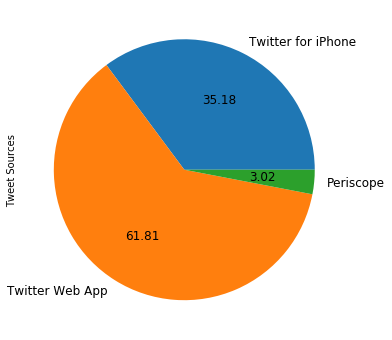

In [384]:
sources = []
for source in df['Source']:
    if source not in sources:
        sources.append(source)
        
        
# We print sources list:

print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

# We create a numpy vector mapped to labels:

percent = np.zeros(len(sources))
 
for source in df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100
    
# Pie chart:

pie_chart = pd.Series(percent, index=sources, name='Tweet Sources')
pie_chart.plot.pie(fontsize=12, autopct='%.2f', figsize=(6, 6));

In [385]:
# Create a series from array
tweets_liked = pd.Series(data = df['Likes'].values)   
tweets_retweeted = pd.Series(data = df['Retweets'].values) 

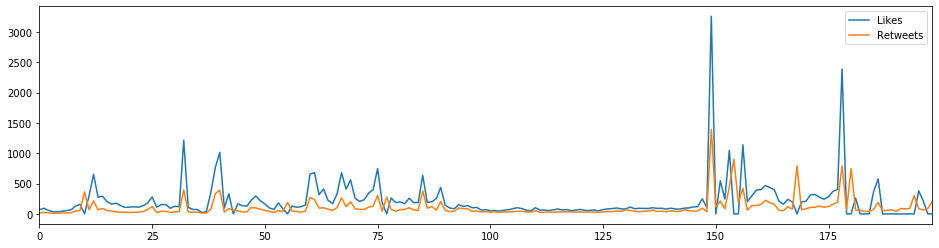

In [386]:
# Likes vs retweets visualization:

# some on tweets have 0 values in Likes column and retweets column it is not missing values 
tweets_liked.plot(figsize=(16,4), label="Likes", legend=True)   
tweets_retweeted.plot(figsize=(16,4), label="Retweets", legend=True)

# 3) Data Preparation

## Clean


###  Since we only need Tweets column therefore I dropped the unnecessary columns, keeping only Tweet's column.

In [387]:
df = df.drop(['ID', 'Date', 'Source', 'Likes', 'Retweets'], axis=1)
df.head(10)

,Tweets
0,This health crisis has already put an immense ...
1,As we put all our resources and energy behind ...
2,I would like to urge participants to discuss m...
3,We have always emphasized the importance of fr...
4,The healthcare system of a nation determines t...
5,"In times like this #COVID19 pandemic, we are o..."
6,"For #Bhutan, we always believe that a nation c..."
7,We are living in extraordinary times. But as m...
8,This #COVID19 pandemic has also put us at a cr...
9,All of us are equal. The #coronavirus certainl...


### Here we are going to clean our Tweets,  we are going to remove : 

1) Links 

2) Special Characters 

3) spaces etc

In [388]:
def clean_tweet(tweet):
    
    """
     Clean data by remove Links, Special Characters etc from tweet
    """
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


for tweet in df['Tweets'][:10]:
    print(clean_tweet(tweet))
    print('\n')

This health crisis has already put an immense burden on our economy and if you are not mindful and strategic it cou


As we put all our resources and energy behind COVID19 let us also remind ourselves not to compromise on the routi


I would like to urge participants to discuss measures to ensure that more vulnerable countries continue to have acc


We have always emphasized the importance of free and quality health care for all and now His Majesty the King is pe


The healthcare system of a nation determines that of an entire globe This is where I see WHO taking a strong lead


In times like this COVID19 pandemic we are once again asked to reflect on the efforts and importance we have plac


For Bhutan we always believe that a nation can only grow on the strong foundation of a good healthcare system Fo


We are living in extraordinary times But as much as there are challenges we are inspired by incredible stories of


This COVID19 pandemic has also put us at a crossroads where leaders

In [389]:
print(df.isnull().sum())

Tweets    0
dtype: int64


In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 1 columns):
Tweets    199 non-null object
dtypes: object(1)
memory usage: 1.6+ KB


# 4) Data Modeling

In [391]:
# creating some variables and list to store info

polarity = 0
positive = 0
negative = 0
neutral = 0
        
positive_word = []
negtive_word = []

#tweets = []
tweet_text = []

# iterating through tweets fetched
for tweet in df['Tweets']:
    
    #print(tweet)
    #print('')
    #Append to temp so that we can store in csv later. I use encode UTF-8
    filtered_tweet = clean_tweet(tweet)
    tweet_text.append(filtered_tweet)
    
    # print (tweet.text.translate(non_bmp_map))    #print tweet's text
    analysis = TextBlob(filtered_tweet)
    
    # print(analysis.sentiment)  # print tweet's polarity
    polarity += analysis.sentiment.polarity
    
    # adding reaction of how people are reacting to find average later
    
    if (analysis.sentiment.polarity == 0): 
        neutral += 1
    elif (analysis.sentiment.polarity > 0 ):
        positive_word.append(filtered_tweet)
        positive += 1
    elif (analysis.sentiment.polarity < 0):
        negtive_word.append(filtered_tweet)
        negative += 1

## Analyze

### 2- Predict writer's attitude or views towards a particular topic, product, etc. regarding sentiments (positive,                  negative, or neutral) in terms of percentage.

In [392]:
def calculate_percentage(part, whole):
    
    """
    Calculate percentage of tweets polarity
    
    """
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')


# finding average of people's sentiments

positive = calculate_percentage(positive, no_of_terms)
negative = calculate_percentage(negative, no_of_terms)
neutral = calculate_percentage(neutral, no_of_terms)

print("Classification of tweets according to the sentments.\n")
print("Percentage of positive tweets: {}%".format(positive))
print("Percentage of neutral tweets: {}%".format(negative))
print("Percentage de negative tweets: {}%".format(neutral))

Classification of tweets according to the sentments.

Percentage of positive tweets: 48.50%
Percentage of neutral tweets: 10.50%
Percentage de negative tweets: 40.50%


# 5) Evaluation and Results

## Visualize 

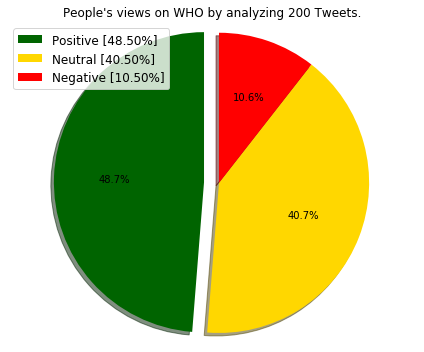

In [393]:
def plot_chart(positive, neutral, negative, search_term, no_of_terms):
    
    """
    Draw pie chart showing classification of sentimets 
    """
     
    labels = ['Positive [' + str(positive) + '%]', 'Neutral [' + str(neutral) + '%]','Negative [' + str(negative) + '%]']
    sizes = [positive, neutral, negative]
    colors = ['darkgreen', 'gold', 'red']
    explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots(figsize=(6, 5))
    ax1.pie(sizes,colors= colors, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
    plt.legend(labels, loc="upper left" , prop={'size': 12})
    plt.title('People\'s views on ' + search_term + ' by analyzing ' + str(no_of_terms) + ' Tweets.')
    ax1.axis('equal')
    plt.tight_layout()
    plt.show()
    

plot_chart(positive, neutral, negative, search_term, no_of_terms)

### 3 -  What is the frequency or the importance of each word in tweets regarding sentiments. 

In [395]:
def draw_wordcloud(tweets, color = 'black'):
    
    """
    Draw a cloud a word from tweets 
    """
    words = ' '.join(tweets)
    cleaned_word = " ".join([word for word in words.split() 
                             if 'http' not in word
                                    and not word.startswith('@')
                                    and not word.startswith('#')
                                    and word != 'RT'
                            ])
    
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color=color,
                          max_words=100,
                          width=3000,
                          height=1000
                         ).generate(cleaned_word)
    plt.figure(figsize=(13, 13))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

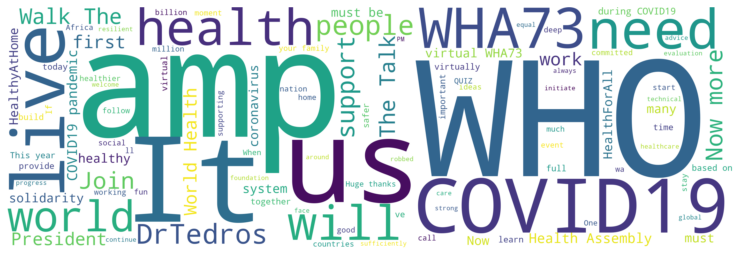

In [396]:
# call function to draw word of cloud with positve sentiments 

draw_wordcloud(positive_word, 'white')

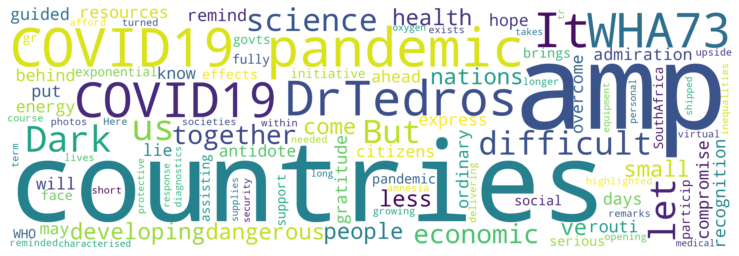

In [397]:
# call function to draw word of cloud with negitive sentiments

draw_wordcloud(negtive_word,'white')

### 4- What are top hashtags in tweets.

In [398]:
def extract_hashtags(tweets):
    
    """
    Collect hashtags from tweets list by find tweets 
    that start with #
    """
    
    hashtags = []
    # Loop over the words in the tweet
    for tweet in tweets:
        hashtag = re.findall(r"#(\w+)", tweet)
        hashtags.append(hashtag)

    return hashtags

# extracting hashtags from tweets
hashtag = extract_hashtags(df['Tweets'])

# unnesting list
hashtag = sum(hashtag,[])

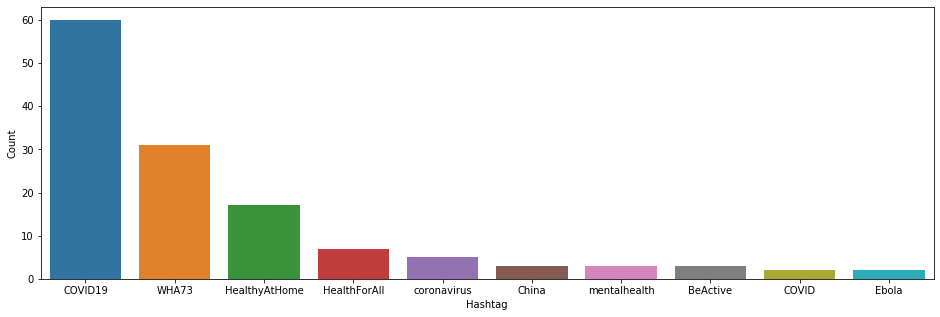

In [399]:
a = nltk.FreqDist(hashtag)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()